

# Predicting wind energy


The two datasets contain the following features.

- P : electrical power

- V : wind speed

- Dir : wind direction in degrees °

- T : temperature




## We present the following things

- Prediction results and error obtained for several machine learning methods for the two wind turbines.
- A discussion about the impact of the hyperparameters of the methods and their calibration on your predictions.
- A clear comparison between your solutions (table, and/or plots comparing the results obtained with different methods).
- Comment about the comparison of both wind turbines.
- A discussion about the difficulties encountered if applicable.
- Aim : best possible predictive performance, in a clean notebook, with clear graphs and explanations.


# Data Visualization


In [264]:
# Base Libraries
import os
import json
import csv
from datetime import datetime, timedelta, date

# Data Manipulation
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 400

from scipy import stats

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set(style='white')

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Data Modeling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
import xgboost as xgb
import pickle
from joblib import dump, load
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [265]:
import warnings
warnings.filterwarnings('ignore')

In [266]:
data = pd.read_csv(filepath_or_buffer='eol1.csv',
                       sep=' ',
                       index_col=0,
                       )

In [267]:
print('Rows: {:>10,}    Cols: {:>10,}'.format(data.shape[0], data.shape[1]))
display(data.head(2))

Rows:      8,616    Cols:          4


,P,V,Dir,T
1,1891.281677,12.025000,176.998334,8.193333
2,1747.884989,11.026667,182.190002,8.171666


In [268]:
############################################################
# Overview of dataset function
############################################################

def df_desc(df, shape_only=False):
    ''' Describe the structure of a dataframe
    '''
    import pandas as pd
    print('Shape of the dataframe:')
    print('{:<10} {:>10,} | {:<10} {:>10,}'.format('Rows:', df.shape[0], 'Columns:', df.shape[1]))
    
    if not shape_only:
        desc = pd.DataFrame({'dtype': df.dtypes,
                             'NAs': df.isna().sum(),
                             '% Missing': np.floor((df.isna().sum() / len(df))*1000)/10,
                             'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                             'Numerical': (df.dtypes != 'object') & (df.dtypes != 'datetime64[ns]') & (df.dtypes != 'datetime64[ns, UTC]') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                             'Date': (pd.core.dtypes.common.is_datetime64_any_dtype(df.dtypes)) | (df.dtypes.isin(['datetime64[ns]', 'datetime64[D]', 'datetime64[ns, UTC]', '<M8[ns]', 'M8[ns]', '<M8[D]', 'M8[D]'])) | (np.issubdtype(df.dtypes, np.datetime64)) | (df.dtypes == np.datetime64),
                             'Categorical': df.dtypes == 'object',
                            })

        date_dtype = [pd.core.dtypes.common.is_datetime64_any_dtype(df[col]) for col in df.columns]            
        desc.Date = date_dtype

        desc.Boolean = desc.Boolean.map({True: 'YES', False: '-'})
        desc.Numerical = desc.Numerical.map({True: 'YES', False: '-'})
        desc.Date = desc.Date.map({True: 'YES', False: '-'})
        desc.Categorical = desc.Categorical.map({True: 'YES', False: '-'})

        desc['Count of Categories'] = [len(df.loc[:,col].unique()) if desc.loc[col,'Categorical'] == 'YES' else '-' for col in df.columns]
        desc['Categories'] = [sorted(list(df.loc[:,col].unique().astype('str'))) if desc.loc[col,'Categorical'] == 'YES' else '-' for col in df.columns]
        
        
        return desc

In [269]:
df_desc(data)

Shape of the dataframe:
Rows:           8,616 | Columns:            4


,dtype,NAs,% Missing,Boolean,Numerical,Date,Categorical,Count of Categories,Categories
P,float64,97,1.1,-,YES,-,-,-,-
V,float64,97,1.1,-,YES,-,-,-,-
Dir,float64,98,1.1,-,YES,-,-,-,-
T,float64,97,1.1,-,YES,-,-,-,-


In [270]:
data = data.dropna()
df_desc(data)

Shape of the dataframe:
Rows:           8,518 | Columns:            4


,dtype,NAs,% Missing,Boolean,Numerical,Date,Categorical,Count of Categories,Categories
P,float64,0,0.0,-,YES,-,-,-,-
V,float64,0,0.0,-,YES,-,-,-,-
Dir,float64,0,0.0,-,YES,-,-,-,-
T,float64,0,0.0,-,YES,-,-,-,-


**Comment** 

We have almost clean data with only 1.1 missing value that we drop. And all the features are numerical.

# Data Analysis:

Having obtained a clean dataset. Now we will try to understand and visualize it for a better understanding 

**Utils functions**

In [273]:
def features_dict(df, target):
    numerical_dtypes   = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_dtypes = ['object']
    num_cols = []
    cat_cols = []
    
    for col in df.columns:
        if col != target:
            if df[col].dtype in numerical_dtypes:
                num_cols.append(col)
            if df[col].dtype in categorical_dtypes:
                cat_cols.append(col)
            
    feat_dict = {'num': num_cols, 'cat': cat_cols}
    
    return feat_dict

In [274]:
def plot_corr_mat(df, selection, key, annot=True, figsize=(12,8)):
    corr_mat = df.loc[:, df.columns.isin(selection)].corr()
    sorted_index = corr_mat.sort_values(key, ascending=False).index
    corr_mat = corr_mat.reindex(sorted_index).reindex(sorted_index, axis=1)
    plt.figure(figsize=figsize)
    sns.heatmap(corr_mat, cmap='RdBu', annot=annot, vmin=-1, vmax=1)
    plt.tight_layout()

In [275]:
def plot_pairgrid(df, selection, key):
    plot = sns.PairGrid(df.loc[:, df.columns.isin(selection)], hue=key, palette=('lightgrey', 'crimson'))
    plot = plot.map_diag(plt.hist)
    plot = plot.map_offdiag(plt.scatter)
    plot.add_legend()
    plt.tight_layout()

In [276]:
def plot_count_cat(df, x,  top=0):
    fig, ax =plt.subplots(1,1, sharey=False, figsize=(20,4)) 
    if top != 0:
        p = sns.countplot(data=df, x=x, palette=['crimson'], order = df[x].value_counts().iloc[:top].index)        
    else:
        p = sns.countplot(data=df, x=x, palette=['crimson'], order = df[x].value_counts().index)
    
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    sns.despine()

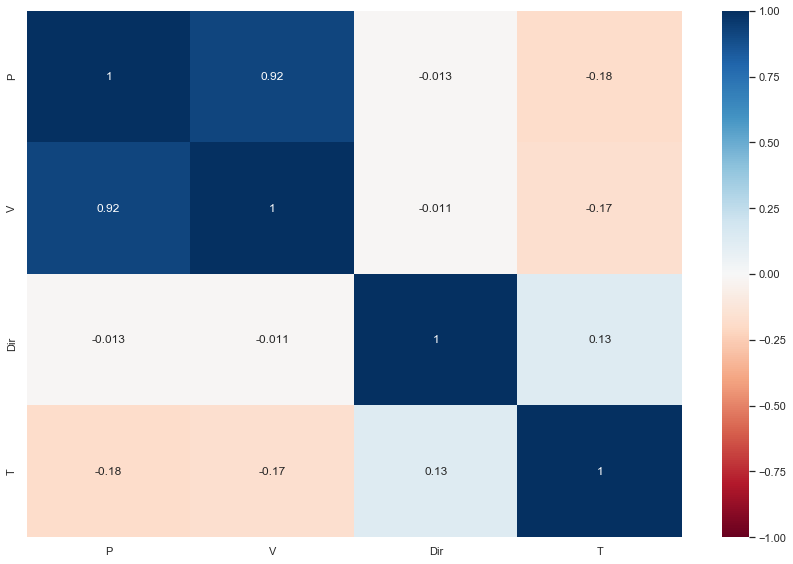

In [277]:
plot_corr_mat(data, data.columns, 'P', annot=True)

**Comment**


The target variable is strongly correlated with V the wind velocity which makes sense if we know that P = 1/2 * Rho * S * V,
where Rho is the yield, S the surface and V the velocity. Our goal is to model P using the dataset we have.


In [278]:
###########################
# Nice distributions plots#
###########################

def plot_dist_num(df, x, key):
    fig, ax =plt.subplots(1,2, sharey=False, sharex=False, figsize=(20, 4)) 

    sns.distplot(df[x], hist=False, color="lightgrey", kde_kws={"shade": True}, ax=ax[0])
    sns.violinplot(x=df[x], palette=["yellow"], ax=ax[1], orient='h')
    
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ["lightgrey", "yellow"])

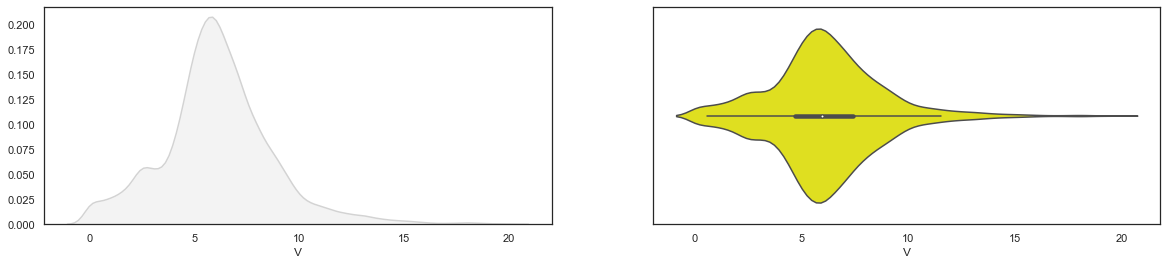

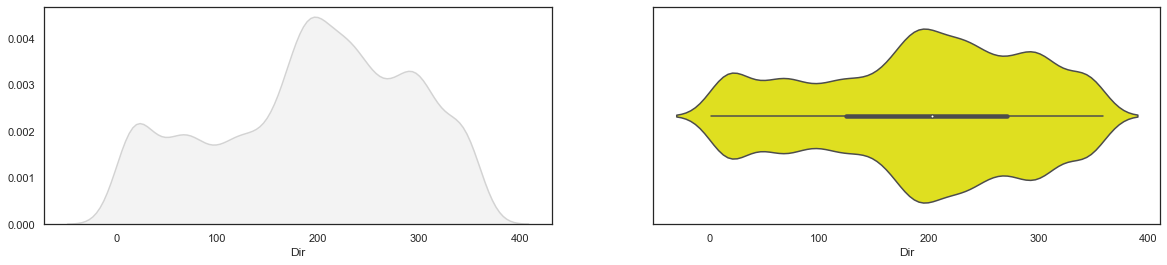

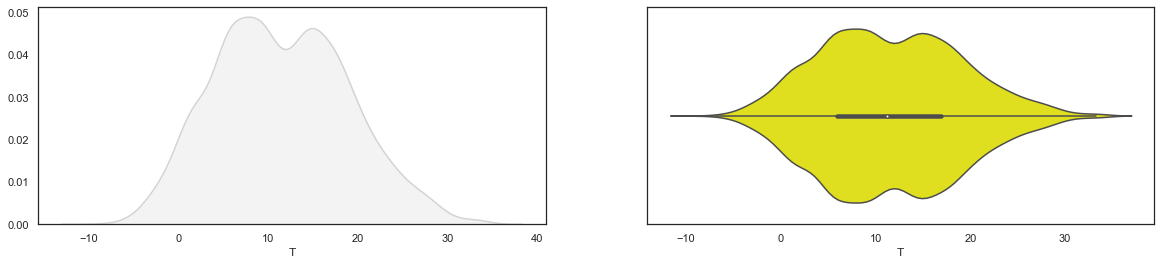

In [279]:
eda_feat_dict = features_dict(data,'P')

eda_contracts_feat_dict = features_dict(data, 'P')

for col in eda_feat_dict['num']:
    plot_dist_num(data, col, 'P')
    plt.close(2)
    plt.show()

In [280]:
variables = ['V', 'Dir', 'T']

# Data Modelling:

We first made some models based on the first dataset in order to evaluate them and pick the best model for our data.
The models tested:
    - Elastic Net
    - Linear Regression
    - Polynomial regression : deg 2, deg 3.
    - Random Forest
    - XGboost.

Then after obtaining the results and comparing them, we took the best model and we optimzed it with hyperparameter tuning.
And finally we used this model and the second dataset to predict the electrical power produced by the wind.

In [281]:
############################
# train/test split function#
############################

def split_dataset(df, target, split_ratio=0.2, seed=888, scaler=None, with_print=True):

    features = list(df.columns)
    features.remove(target)

    X = df[features]
    y = df[[target]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=split_ratio, random_state=seed)

    if scaler != None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

    if with_print:
        print('{:<20} {:>10,} {} | {:>10,} {}'.format('Features:', X.shape[0],       'rows', X.shape[1],       'columns'))
        print('{:<20} {:>10,} {} | {:>10,} {}'.format('Target:', y.shape[0],       'rows', y.shape[1],       'columns'))
        print('{:<20} {:>10,} {} | {:>10,} {}'.format('Features Train:', X_train.shape[0], 'rows', X_train.shape[1], 'columns'))
        print('{:<20} {:>10,} {} | {:>10,} {}'.format('Features Test:', X_test.shape[0],  'rows', X_test.shape[1],  'columns'))
        print('{:<20} {:>10,} {} | {:>10,} {}'.format('Target Train:', y_train.shape[0], 'rows', y_train.shape[1], 'columns'))
        print('{:<20} {:>10,} {} | {:>10,} {}'.format('Target Test:', y_test.shape[0],  'rows', y_test.shape[1],  'columns'))
        print()

    return X_train, X_test, y_train, y_test

In [282]:
############################################################
# Cross-validation function
############################################################


def cv_kfold(model, X_train, y_train, scoring, n_splits, seed):
    kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    results = cross_val_score(
        model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
    return results

In [283]:
##############################
# Feature importance function#
##############################

def display_feature_importance(X_train, model, display_=True):
    try:
        feature_weight = pd.DataFrame(
            [X_train.columns, model.feature_importances_], index=['Feature', 'Weight']).T
        pass
    except (TypeError, AttributeError):
        if len(model.coef_) != 1:
            feature_weight = pd.DataFrame(
                [X_train.columns, model.coef_], index=['Feature', 'Weight']).T
        else:
            feature_weight = pd.DataFrame(
                [X_train.columns, model.coef_[0]], index=['Feature', 'Weight']).T
    feature_weight['abs(weight)'] = abs(feature_weight['Weight'])
    feature_weight = feature_weight.sort_values('abs(weight)', ascending=False)
    feature_weight['Rank'] = np.arange(len(feature_weight)) + 1
    if display_ == True:
        display(feature_weight)
    else:
        return feature_weight

In [284]:
##############################
# Regression generic pipeline#
##############################

def pipeline(model, df, target, scoring='neg_mean_absolute_error', split_ratio=0.2, 
             n_splits=10, seed=888, scaler=None,
             dump_path=None, model_name='power', silent=False, grid=None):

    start_time = datetime.now()

    # Train/Test Split
    X_train, X_test, y_train, y_test = split_dataset(
        df, target, split_ratio, seed, scaler)


    if grid == None:
        # Training
        model.fit(X_train, y_train)
        y_pred = pd.DataFrame(model.predict(X_test), columns=['prediction'])
        score = model.score(X_test, y_test)

        # Regression metrics
        explained_variance = metrics.explained_variance_score(y_test, y_pred)*100
        mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
        mean_absolute_percentage_error = metrics.mean_absolute_error(y_test/np.array(y_test), y_pred/np.array(y_test))*100
        mse = metrics.mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        median_absolute_error = metrics.median_absolute_error(y_test, y_pred)


        df_metrics = pd.DataFrame(data={
            'explained variance %': [round(explained_variance, 2)],
            'MAE': [round(mean_absolute_error, 2)],
            'MAPE %': [round(mean_absolute_percentage_error, 2)],
            'MSE': [round(mse, 5)],
            'RMSE': [round(rmse, 5)],
            'Median absolute error': [round(median_absolute_error, 2)],
        }).rename(index={0: 'value of metric'}).T

        # Cross-Validation
        cv_results = cv_kfold(model, X_train, y_train.values.ravel(), scoring, n_splits, seed)

        end_time = datetime.now()

        if dump_path != None:
            model_file = model_name + '_' + \
                end_time.strftime('%y%m%d_%H%M%S') + '_model.joblib'
            dump(model, os.path.join(dump_path, model_file))        
        
        training_time = end_time - start_time
        training_time_hours = int(training_time.total_seconds() // 3600)
        training_time_minutes = int(
            (training_time.total_seconds() - training_time_hours * 3600) // 60)
        training_time_seconds = int(training_time.total_seconds(
        ) - training_time_hours * 3600 - training_time_minutes * 60)

        dict_results = {'explained variance %': round(explained_variance, 2),
                        'MAE': round(mean_absolute_error, 2),
                        'MAPE': round(mean_absolute_percentage_error, 2),
                        'MSE': round(mse, 2),
                        'RMSE': round(rmse, 2),
                        'Median absolute error': round(median_absolute_error, 2),
                        'training_time': training_time}
        results_file = model_name + '_' + \
            end_time.strftime('%y%m%d_%H%M%S') + '_results.p'

        if dump_path != None:
            with open(os.path.join(dump_path, results_file), 'wb') as file:
                pickle.dump(dict_results, file,
                            protocol=pickle.HIGHEST_PROTOCOL)

        if not silent:
            print('*'*120)
            print('Training Time: {:02d}:{:02d}:{:02d}'.format(
                training_time_hours, training_time_minutes, training_time_seconds))
            print('*'*120)
            print('{:02d}{:14}{}: {:>.3f}'.format(
                n_splits, '-Fold CV Mean ', scoring.capitalize(), cv_results.mean()))
            str_cv_results = str(
                {i+1: np.round(cv_results[i], 3) for i in range(len(cv_results))})[1:-1]
            print('{:<10} [{}]\n'.format('Iterations:', str_cv_results))
            print('*'*120)
            print('Main metrics over test: ')
            display(df_metrics)
            
            # feature importance
            feature_imp = display_feature_importance(X_train, model,display_=False)
            
            print('*'*120)
            print('Plots')

            # Plots
            
            if feature_imp["abs(weight)"].sum()==0:
                fig, ax =plt.subplots(2,1, sharey=False, figsize=(10,15))
            else:
                fig, ax =plt.subplots(3,1, sharey=False, figsize=(10,15))
            
            # Error plot
            sns.distplot(np.array(y_test)-np.array(y_pred),ax=ax[0])
            #ax[0].set_xlim([-3,3])
            ax[0].set_xlabel(r'$\mathcal{Error} = y_{pred}-y_{true}$')
            ax[0].set_ylabel(r'distribution')
            ax[0].grid()

            df_cv = pd.DataFrame(cv_results,columns=['violinplot - cv scoring results'])
            sns.violinplot(x="violinplot - cv scoring results", data=df_cv,ax=ax[1])
            ax[1].grid()
            
            if feature_imp["abs(weight)"].sum()!=0:
                sns.barplot(x='abs(weight)', y="Feature", 
                            data=feature_imp, 
                            order=feature_imp.sort_values('abs(weight)',ascending = False).Feature)

            plt.legend()
            plt.show()
        return model, dict_results
    else:
        model.fit(X_train, y_train.values.ravel())
        print(model.best_score_)
        print(model.best_params_)

Features:                 8,518 rows |          3 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |          3 columns
Features Test:            1,704 rows |          3 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Training Time: 00:00:00
************************************************************************************************************************
10-Fold CV Mean Neg_mean_absolute_error: -195.266
Iterations: [1: -200.714, 2: -203.347, 3: -194.281, 4: -199.065, 5: -185.936, 6: -202.656, 7: -186.211, 8: -203.993, 9: -189.532, 10: -186.922]

************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,75.37000
MAE,190.07000
MAPE %,1035.12000
MSE,55768.72565
RMSE,236.15403
Median absolute error,173.49000


************************************************************************************************************************
Plots


No handles with labels found to put in legend.


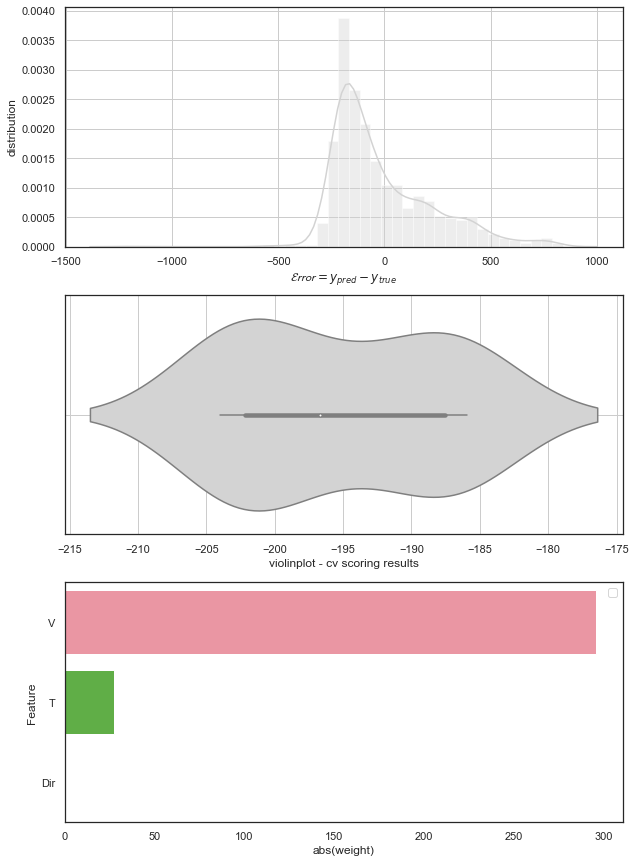

In [285]:
####################
# Elastic Net model#
####################

lr, dict_results = pipeline(ElasticNet(), data[variables+['P']], 'P',scaler=StandardScaler())

Features:                 8,518 rows |          3 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |          3 columns
Features Test:            1,704 rows |          3 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Training Time: 00:00:04
************************************************************************************************************************
10-Fold CV Mean Neg_mean_absolute_error: -143.807
Iterations: [1: -153.287, 2: -143.696, 3: -140.989, 4: -143.306, 5: -143.163, 6: -144.754, 7: -143.542, 8: -143.889, 9: -143.301, 10: -138.147]

************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,82.93000
MAE,140.42000
MAPE %,3270.41000
MSE,41578.89297
RMSE,203.90903
Median absolute error,95.40000


No handles with labels found to put in legend.


************************************************************************************************************************
Plots


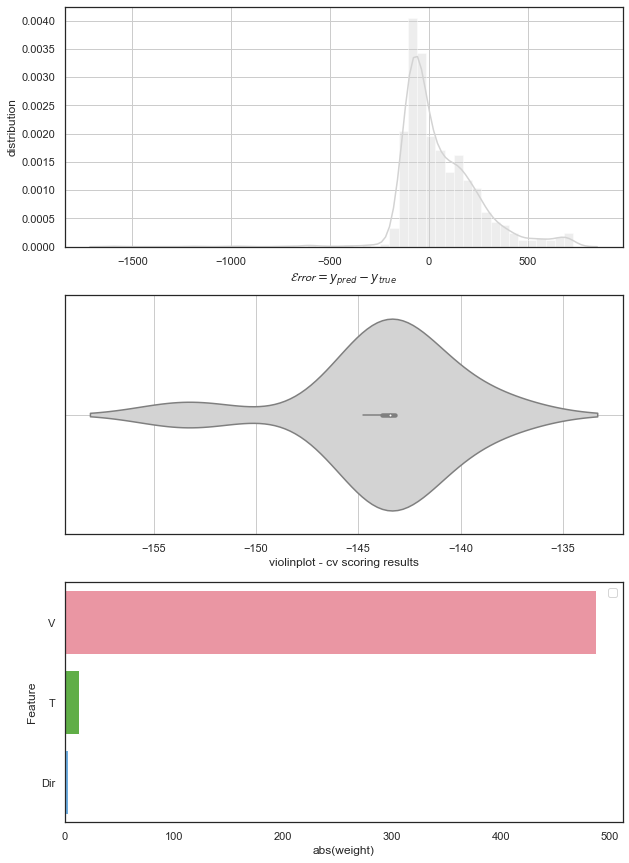

In [286]:
rg, dict_results = pipeline(SVR( kernel = 'linear'), data[variables+['P']], 'P',scaler=StandardScaler())

Features:                 8,518 rows |         10 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |         10 columns
Features Test:            1,704 rows |         10 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Training Time: 00:00:00
************************************************************************************************************************
10-Fold CV Mean Neg_mean_absolute_error: -128.435
Iterations: [1: -140.317, 2: -130.7, 3: -125.642, 4: -130.848, 5: -121.909, 6: -127.738, 7: -125.182, 8: -127.667, 9: -124.905, 10: -129.442]

************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,86.93000
MAE,125.24000
MAPE %,1494.10000
MSE,29540.41676
RMSE,171.87326
Median absolute error,107.99000


************************************************************************************************************************
Plots


No handles with labels found to put in legend.


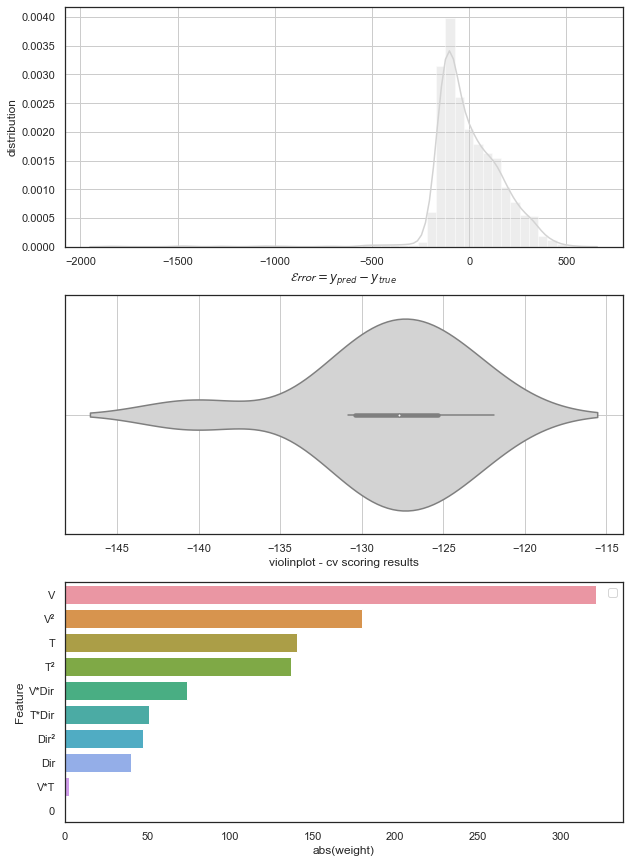

In [287]:
############################
#Modele polynomiale deg = 2#
############################


poly_reg = PolynomialFeatures(degree=2)
X = data
X_poly= poly_reg.fit_transform(X[variables])

col = ['0','V','Dir','T','V²','Dir²','T²','V*Dir','V*T','T*Dir']
df = pd.DataFrame (X_poly, columns=col)

df['P']=pd.DataFrame (data['P'].reset_index(drop=True), columns=['P'])

lin_reg2 = LinearRegression()


Poly2, dict_results = pipeline(lin_reg2, df[col+['P']], 'P',scaler=StandardScaler())


Features:                 8,518 rows |         20 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |         20 columns
Features Test:            1,704 rows |         20 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Training Time: 00:00:00
************************************************************************************************************************
10-Fold CV Mean Neg_mean_absolute_error: -63.966
Iterations: [1: -68.551, 2: -65.168, 3: -61.894, 4: -66.078, 5: -58.51, 6: -63.377, 7: -64.838, 8: -64.985, 9: -63.106, 10: -63.155]

************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,95.88000
MAE,63.63000
MAPE %,677.35000
MSE,9322.78043
RMSE,96.55455
Median absolute error,51.59000


************************************************************************************************************************
Plots


No handles with labels found to put in legend.


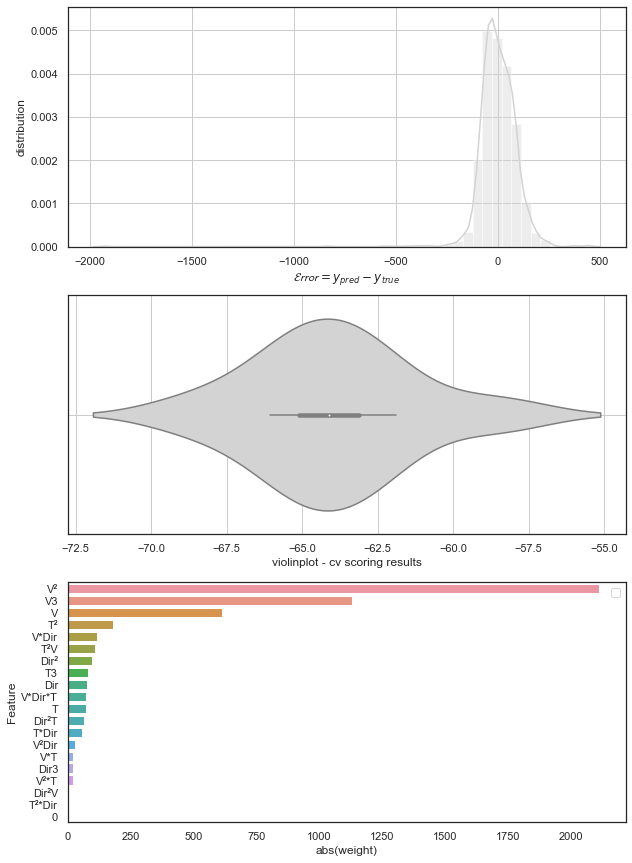

In [288]:
############################
#Modele polynomiale deg = 3#
############################


poly_reg = PolynomialFeatures(degree=3)
X = data
X_poly= poly_reg.fit_transform(X[variables])

col = ['0','V','Dir','T','V²','Dir²','T²','V*Dir','V*T','T*Dir','V3','Dir3','T3','V²Dir','Dir²T','T²V','V*Dir*T','V²*T','T²*Dir','Dir²V']
df = pd.DataFrame (X_poly, columns = col)

df['P']=pd.DataFrame (data['P'].reset_index(drop=True), columns=['P'])

lin_reg2 = LinearRegression()


Poly3, dict_results = pipeline(lin_reg2, df, 'P',scaler=StandardScaler())


# Comment:

This is an important result that shows the importance of the wind velocity and its value raised to the power of 2 and 3.
these three components give us a very close approximation of the target value P. Therefore it is worth making a model based only on V :


Features:                 8,518 rows |          4 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |          4 columns
Features Test:            1,704 rows |          4 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Training Time: 00:00:00
************************************************************************************************************************
10-Fold CV Mean Neg_mean_absolute_error: -66.474
Iterations: [1: -71.252, 2: -65.915, 3: -63.467, 4: -68.309, 5: -62.386, 6: -67.007, 7: -67.383, 8: -69.626, 9: -66.474, 10: -62.923]

************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,95.77000
MAE,64.74000
MAPE %,730.86000
MSE,9546.45372
RMSE,97.70596
Median absolute error,53.37000


************************************************************************************************************************
Plots


No handles with labels found to put in legend.


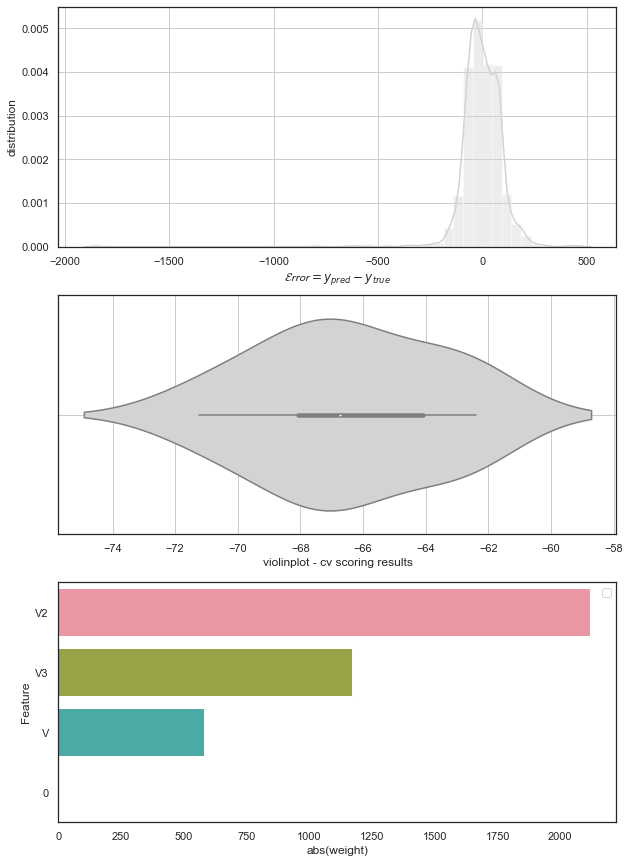

In [289]:
##########################################
#Modele polynomiale deg = 3 with velocity#
##########################################


poly_reg = PolynomialFeatures(degree=3)
X = pd.DataFrame (data['V'], columns = ['V'])
X_poly= poly_reg.fit_transform(X)

col = ['0','V','V2','V3']
df = pd.DataFrame (X_poly, columns = col)

df['P']=pd.DataFrame (data['P'].reset_index(drop=True), columns=['P'])

lin_reg2 = LinearRegression()


Poly4, dict_results = pipeline(lin_reg2, df, 'P',scaler=StandardScaler())


Features:                 8,518 rows |          3 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |          3 columns
Features Test:            1,704 rows |          3 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Training Time: 00:00:07
************************************************************************************************************************
10-Fold CV Mean Neg_mean_absolute_error: -38.758
Iterations: [1: -40.825, 2: -40.758, 3: -36.095, 4: -40.709, 5: -34.189, 6: -40.851, 7: -41.036, 8: -40.389, 9: -36.453, 10: -36.275]

************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,97.16000
MAE,37.98000
MAPE %,107.26000
MSE,6411.27802
RMSE,80.07046
Median absolute error,21.69000


No handles with labels found to put in legend.


************************************************************************************************************************
Plots


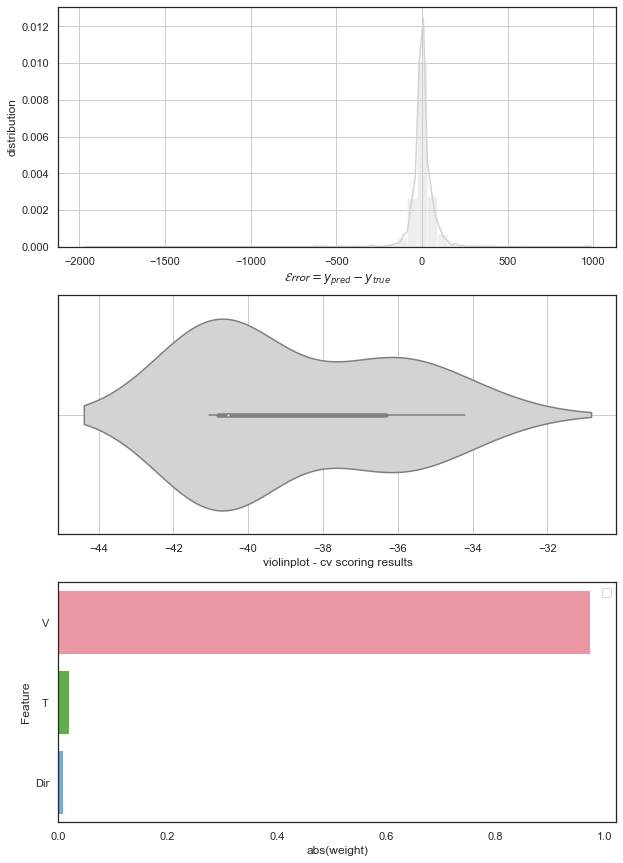

In [290]:
RF, dict_results = pipeline(RandomForestRegressor(max_depth=20), data[variables+['P']], 'P')

Features:                 8,518 rows |          3 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |          3 columns
Features Test:            1,704 rows |          3 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Training Time: 00:00:17
************************************************************************************************************************
10-Fold CV Mean Neg_mean_absolute_error: -41.856
Iterations: [1: -42.334, 2: -42.197, 3: -40.271, 4: -42.616, 5: -37.453, 6: -42.841, 7: -43.302, 8: -43.912, 9: -39.679, 10: -43.958]

************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,96.94000
MAE,39.71000
MAPE %,106.72000
MSE,6915.96152
RMSE,83.16226
Median absolute error,23.06000


No handles with labels found to put in legend.


************************************************************************************************************************
Plots


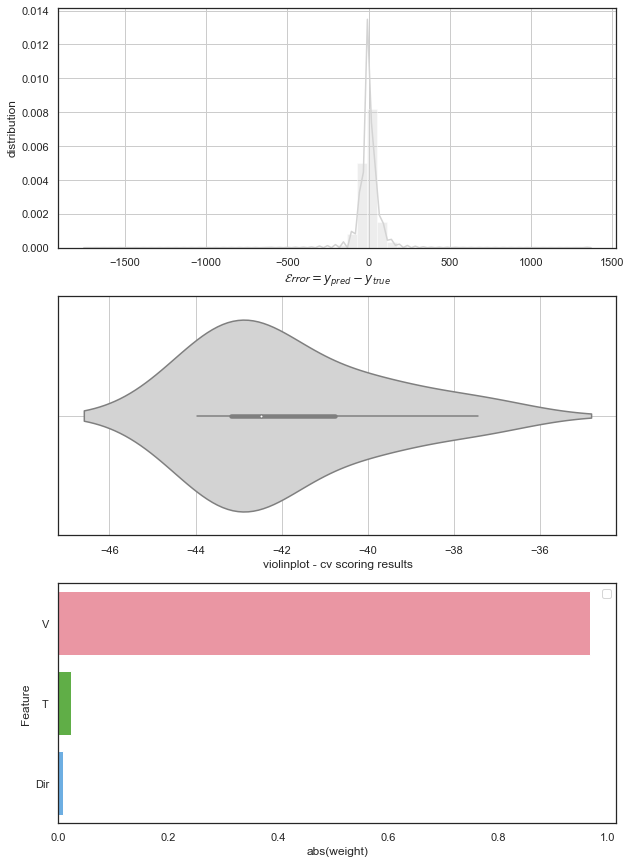

In [291]:
xgboost, dict_results = pipeline(xgb.XGBRegressor(max_depth=20), data[variables+['P']], 'P')

In [296]:
optimzer_dict_to_pass = {'base_estimator': 'GP', 'random_state': 42}

param_grid = {
    'n_estimators': (44, 500),
    'max_features': ["auto", "sqrt", "log2"],
    'bootstrap': [True, False],
    'min_samples_split': (2, 10),
    'max_depth': (2, 75),
    'warm_start': [False],
    'random_state': [42]
}

############################################################
# Bayesian Hyperparameter tuning pipeline 
############################################################


def bayes_tuner(model, df, target, grid_search_model, model_scoring='neg_mean_absolute_error', 
                split_ratio=0.2, nb_cv_splits=5, optimizer=optimzer_dict_to_pass, nb_iter=50, 
                cv_shuffle=True, verbose=0, seed=888, refit=True, return_train_score=False, 
                scaler=None, model_name='power', dump_path=None,silent=False):

    start_time = datetime.now()

    # Train/Test Split
    X_train, X_test, y_train, y_test = split_dataset(
        df, target, split_ratio, seed, scaler)

    bayer_cv_tuner = BayesSearchCV(
        estimator=model,
        search_spaces=grid_search_model,
        optimizer_kwargs=optimizer,
        scoring=model_scoring,
        cv=KFold(n_splits=nb_cv_splits, shuffle=cv_shuffle,
                 random_state=seed),
        n_jobs=-1,
        n_iter=nb_iter,
        verbose=verbose,
        refit=refit,
        random_state=seed,
        return_train_score=return_train_score
    )
    print("*"*120)
    print("Calculating Optimal Hyperparameters ... \n")
    bayer_cv_tuner.fit(X_train, y_train)
    print("Done .. the best score found is : {}".format(
        bayer_cv_tuner.best_score_))
    print("*"*120)
    model = model.set_params(**bayer_cv_tuner.best_params_)

    # Training
    model.fit(X_train, y_train)
    y_pred = pd.DataFrame(model.predict(X_test), columns=['prediction'])
    score = model.score(X_test, y_test)

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_test, y_pred)*100
    mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
    mean_absolute_percentage_error = metrics.mean_absolute_error(
        y_test/np.array(y_test), y_pred/np.array(y_test))*100
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    median_absolute_error = metrics.median_absolute_error(y_test, y_pred)

    df_metrics = pd.DataFrame(data={
        'explained variance %': [round(explained_variance, 2)],
        'MAE': [round(mean_absolute_error, 2)],
        'MAPE %': [round(mean_absolute_percentage_error, 2)],
        'MSE': [round(mse, 2)],
        'RMSE': [round(rmse, 2)],
        'Median absolute error': [round(median_absolute_error, 2)],
    }).rename(index={0: 'value of metric'}).T

    end_time = datetime.now()

    if dump_path != None:
        model_file = model_name + '_BayesTuned_' + \
            end_time.strftime('%y%m%d_%H%M%S') + '_model.joblib'
        dump(model, os.path.join(dump_path, model_file))

    training_time = end_time - start_time
    training_time_hours = int(training_time.total_seconds() // 3600)
    training_time_minutes = int(
        (training_time.total_seconds() - training_time_hours * 3600) // 60)
    training_time_seconds = int(training_time.total_seconds(
    ) - training_time_hours * 3600 - training_time_minutes * 60)

    dict_results = {'explained variance %': round(explained_variance, 2),
                    'MAE': round(mean_absolute_error, 2),
                    'MAPE': round(mean_absolute_percentage_error, 2),
                    'MSE': round(mse, 4),
                    'RMSE': round(rmse, 4),
                    'Median absolute error': round(median_absolute_error, 4),
                    'training_time': training_time}
    results_file = model_name + '_' + \
        end_time.strftime('%y%m%d_%H%M%S') + '_results.p'

    if dump_path != None:
        with open(os.path.join(dump_path, results_file), 'wb') as file:
            pickle.dump(dict_results, file,
                        protocol=pickle.HIGHEST_PROTOCOL)

    if not silent:
        print('*'*120)
        print('Training Time: {:02d}:{:02d}:{:02d}'.format(
            training_time_hours, training_time_minutes, training_time_seconds))

        print('*'*120)
        print('Main metrics over test: ')
        display(df_metrics)

        # feature importance
        feature_imp = display_feature_importance(
            X_train, model, display_=False)

        print('*'*120)
        print('Plots')

        # Plots

        fig, ax = plt.subplots(2, 1, sharey=False, figsize=(10, 15))

        # Error plot
        sns.distplot(np.array(y_test)-np.array(y_pred), ax=ax[0])
        #ax[0].set_xlim([-3,3])
        ax[0].set_xlabel(r'$\mathcal{Error} = y_{pred}-y_{true}$')
        ax[0].set_ylabel(r'distribution')
        ax[0].grid()

        sns.barplot(x='abs(weight)',
                    y="Feature",
                    data=feature_imp,
                    order=feature_imp.sort_values('abs(weight)', ascending=False).Feature)

        plt.legend()
        plt.show()
        
    return model, dict_results

Features:                 8,518 rows |          3 columns
Target:                   8,518 rows |          1 columns
Features Train:           6,814 rows |          3 columns
Features Test:            1,704 rows |          3 columns
Target Train:             6,814 rows |          1 columns
Target Test:              1,704 rows |          1 columns

************************************************************************************************************************
Calculating Optimal Hyperparameters ... 

Done .. the best score found is : -38.4936777019473
************************************************************************************************************************
************************************************************************************************************************
Training Time: 00:02:07
************************************************************************************************************************
Main metrics over test: 


,value of metric
explained variance %,97.38
MAE,37.10
MAPE %,106.98
MSE,5928.88
RMSE,77.00
Median absolute error,21.67


No handles with labels found to put in legend.


************************************************************************************************************************
Plots


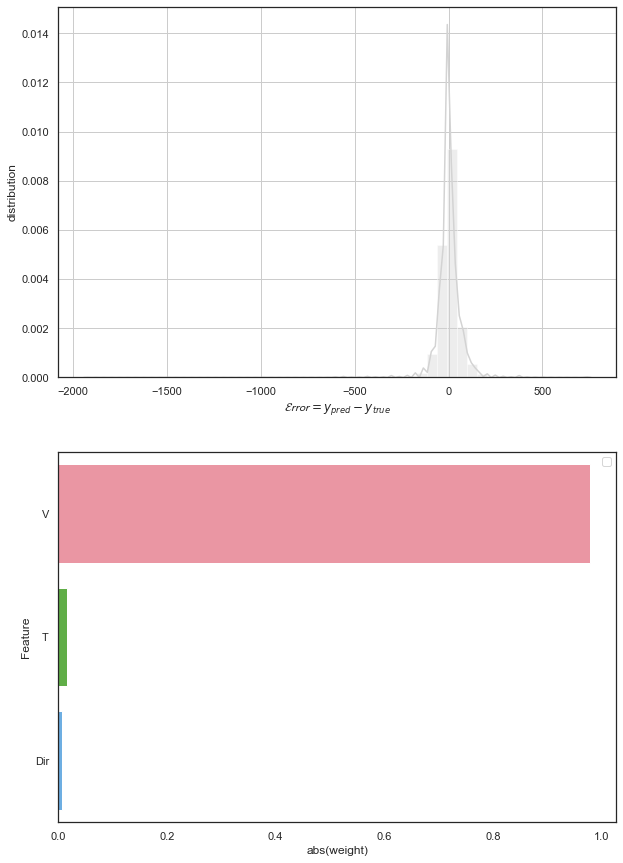

In [297]:
rf_opt, dict_results = bayes_tuner(RandomForestRegressor(), data[variables+['P']], 'P', grid_search_model = param_grid,nb_iter=20)

# Predictions for the second dataset:


In [300]:
data2 = pd.read_csv(filepath_or_buffer='eol2.csv',
                       sep=' ',
                       index_col=0,
                       )
X = data2.dropna()
X_V = X[variables]


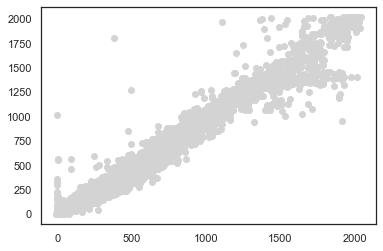

In [301]:
y_pred = rf_opt.predict(X_V)
y_reel = X['P']

plt.scatter(y_reel, y_pred)


In [303]:
 # Regression metrics
explained_variance = metrics.explained_variance_score(y_reel, y_pred)*100
mean_absolute_error = metrics.mean_absolute_error(y_reel, y_pred)
mean_absolute_percentage_error = metrics.mean_absolute_error(y_reel/np.array(y_reel), y_pred/np.array(y_reel))*100
mse = metrics.mean_squared_error(y_reel, y_pred)
rmse = np.sqrt(mse)
median_absolute_error = metrics.median_absolute_error(y_reel, y_pred)

df_metrics = pd.DataFrame(data={
        'explained variance %': [round(explained_variance, 2)],
        'MAE': [round(mean_absolute_error, 2)],
        'MAPE %': [round(mean_absolute_percentage_error, 2)],
        'MSE': [round(mse, 2)],
        'RMSE': [round(rmse, 2)],
        'Median absolute error': [round(median_absolute_error, 2)],
    }).rename(index={0: 'value of metric'}).T
display(df_metrics)



,value of metric
explained variance %,97.26
MAE,41.92
MAPE %,133.69
MSE,6068.92
RMSE,77.90
Median absolute error,19.52


# Conclusion:

we clearly see that our model is a good prediction of the electrical power produced by the wind since almost all the predicted values lie on the y=x graph with good variance and error values.